In [29]:
import sys
sys.path.insert(0, '..')

import polars as pl
import numpy as np
from pathlib import Path

# Load the final analysis data
data_path = Path('../data/processed/df_final_analysis.parquet')
df = pl.read_parquet(data_path)

print(f"Final analysis data loaded!")
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns}")
print(f"\nData types:")
print(df.schema)
print(f"\nFirst few rows:")
print(df.head())

Final analysis data loaded!
Shape: (412, 8)

Columns: ['time', 'speaker', 'party', 'speech', 'topic', 'topic_confidence', 'sentiment', 'unique_id']

Data types:
Schema([('time', String), ('speaker', String), ('party', Int64), ('speech', String), ('topic', String), ('topic_confidence', Float64), ('sentiment', String), ('unique_id', String)])

First few rows:
shape: (5, 8)
┌─────────────┬─────────────┬───────┬────────────┬────────────┬────────────┬───────────┬───────────┐
│ time        ┆ speaker     ┆ party ┆ speech     ┆ topic      ┆ topic_conf ┆ sentiment ┆ unique_id │
│ ---         ┆ ---         ┆ ---   ┆ ---        ┆ ---        ┆ idence     ┆ ---       ┆ ---       │
│ str         ┆ str         ┆ i64   ┆ str        ┆ str        ┆ ---        ┆ str       ┆ str       │
│             ┆             ┆       ┆            ┆            ┆ f64        ┆           ┆           │
╞═════════════╪═════════════╪═══════╪════════════╪════════════╪════════════╪═══════════╪═══════════╡
│ 2010-05-20T ┆ burk

In [30]:
# Data preparation: Convert time column and create time periods
import polars as pl

# Convert time to datetime if it's a string
if df.schema['time'] == pl.Utf8:
    df = df.with_columns(
        pl.col('time').str.to_datetime().alias('time')
    )

# Extract year and month for time series analysis
df = df.with_columns([
    pl.col('time').dt.year().alias('year'),
    pl.col('time').dt.month().alias('month'),
    pl.col('time').dt.strftime('%Y-%m').alias('year_month')
])

# Map party IDs to party names
party_name_map = {
    -1: 'Non-MP',
    3: 'Greens',
    4: 'CDU',
    6: 'Left',
    7: 'DP',
    13: 'FDP',
    14: 'Zentrum',
    23: 'SPD'
}

df = df.with_columns(
    pl.col('party').replace_strict(party_name_map, default='Unknown').alias('party_name')
)

# Convert sentiment to numeric score using map_dict (more reliable)
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
df = df.with_columns(
    pl.col('sentiment').replace_strict(sentiment_map, default=0).cast(pl.Int64).alias('sentiment_score')
)

print("Data preparation complete!")
print(f"\nTime range: {df['time'].min()} to {df['time'].max()}")
print(f"\nYears in data: {sorted(df['year'].unique().to_list())}")
print(f"\nUnique topics: {df['topic'].n_unique()}")
print(f"Unique parties: {df['party'].n_unique()}")
print(f"\nParty name mapping:")
for party_id, name in sorted(party_name_map.items()):
    count = df.filter(pl.col('party') == party_id).shape[0]
    print(f"  {party_id} -> {name}: {count} speeches")
unknown_count = df.filter(pl.col('party_name') == 'Unknown').shape[0]
print(f"  Unknown: {unknown_count} speeches")
print(f"\nSentiment values: {df['sentiment'].unique().to_list()}")
print(f"Sentiment score values: {df['sentiment_score'].unique().to_list()}")

Data preparation complete!

Time range: 1952-01-16 00:00:00 to 2020-09-29 00:00:00

Years in data: [1952, 1953, 1954, 1956, 1957, 1959, 1961, 1964, 1967, 1968, 1969, 1971, 1974, 1975, 1977, 1978, 1980, 1982, 1983, 1984, 1985, 1986, 1987, 1989, 1991, 1992, 1995, 1996, 1997, 1998, 1999, 2002, 2003, 2006, 2008, 2009, 2010, 2012, 2013, 2018, 2019, 2020]

Unique topics: 18
Unique parties: 7

Party name mapping:
  -1 -> Non-MP: 0 speeches
  3 -> Greens: 5 speeches
  4 -> CDU: 236 speeches
  6 -> Left: 0 speeches
  7 -> DP: 1 speeches
  13 -> FDP: 29 speeches
  14 -> Zentrum: 1 speeches
  23 -> SPD: 95 speeches
  Unknown: 45 speeches

Sentiment values: ['negative', 'positive', 'neutral']
Sentiment score values: [-1, 0, 1]


## 1. Topic Frequency Over Time

How often was each topic discussed over time?

Top 8 topics for visualization: ['Government', 'Civil', 'International', 'Macroeconomics', 'Law', 'Labor', 'Social', 'Defense']


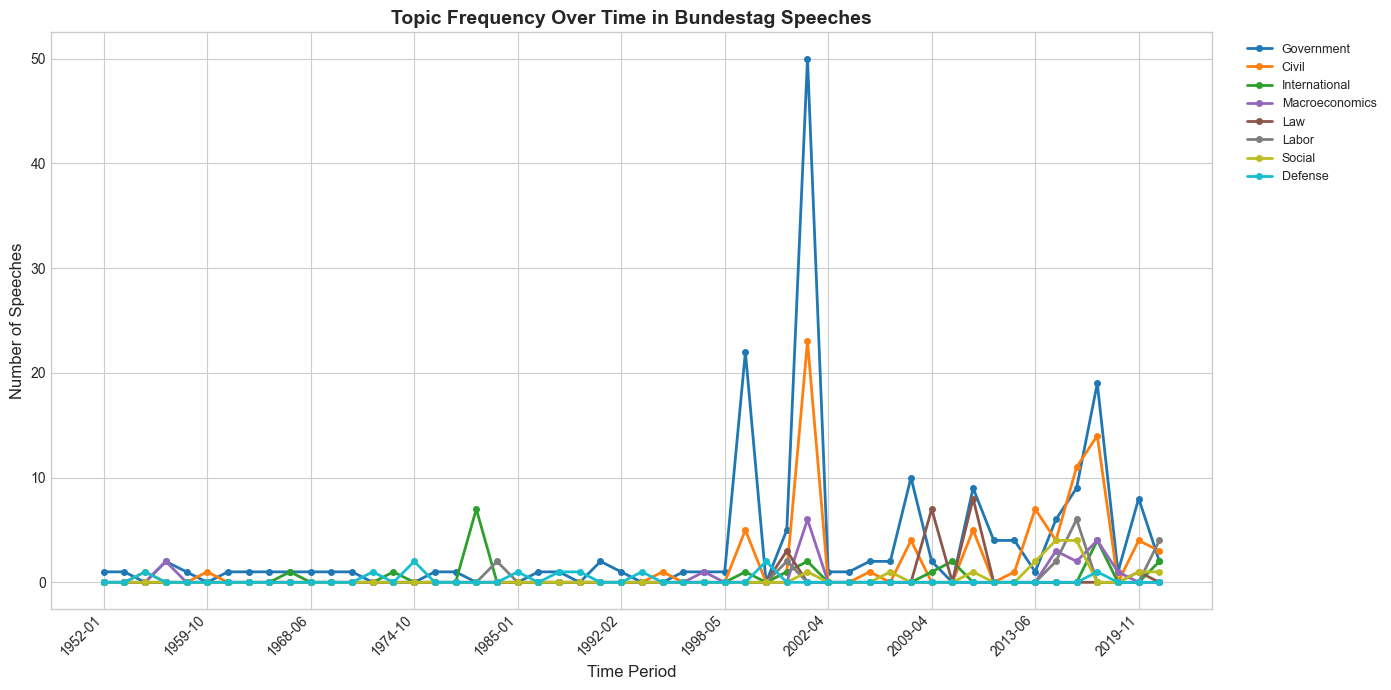


✓ Plot saved to reports/figures/topic_frequency_over_time.png


In [31]:
# Import matplotlib here (first import can be slow due to backend initialization)
import matplotlib.pyplot as plt

# Set style for better plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Calculate topic frequency over time (by year-month)
topic_time = (
    df.group_by(['year_month', 'topic'])
    .agg(pl.len().alias('count'))
    .sort(['year_month', 'topic'])
)

# Get top 8 most common topics overall for cleaner visualization
top_topics = (
    df.group_by('topic')
    .agg(pl.len().alias('total'))
    .sort('total', descending=True)
    .head(8)['topic'].to_list()
)

print(f"Top 8 topics for visualization: {top_topics}")

# Filter to top topics and pivot for plotting
topic_time_top = topic_time.filter(pl.col('topic').is_in(top_topics))

# Create the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Get unique time periods and topics
time_periods = sorted(topic_time_top['year_month'].unique().to_list())

# Plot each topic as a line
colors = plt.cm.tab10(np.linspace(0, 1, len(top_topics)))

for i, topic in enumerate(top_topics):
    topic_data = topic_time_top.filter(pl.col('topic') == topic)
    
    # Create a complete time series (fill missing with 0)
    counts_dict = dict(zip(
        topic_data['year_month'].to_list(),
        topic_data['count'].to_list()
    ))
    counts = [counts_dict.get(t, 0) for t in time_periods]
    
    ax.plot(range(len(time_periods)), counts, label=topic, color=colors[i], 
            linewidth=2, marker='o', markersize=4)

# Customize plot
ax.set_xlabel('Time Period', fontsize=12)
ax.set_ylabel('Number of Speeches', fontsize=12)
ax.set_title('Topic Frequency Over Time in Bundestag Speeches', fontsize=14, fontweight='bold')

# Set x-axis labels
tick_positions = range(0, len(time_periods), max(1, len(time_periods)//10))
ax.set_xticks(tick_positions)
ax.set_xticklabels([time_periods[i] for i in tick_positions], rotation=45, ha='right')

ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.savefig('../reports/figures/topic_frequency_over_time.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Plot saved to reports/figures/topic_frequency_over_time.png")

## 2. Most Relevant Topics - Summary Table

Which topics are most frequently discussed in Bundestag speeches?

In [32]:
# Create comprehensive topic relevance table
topic_summary = (
    df.group_by('topic')
    .agg([
        pl.len().alias('total_speeches'),
        pl.col('topic_confidence').mean().alias('avg_confidence'),
        pl.col('sentiment_score').mean().alias('avg_sentiment'),
        pl.col('party').n_unique().alias('parties_discussing'),
        pl.col('speaker').n_unique().alias('unique_speakers')
    ])
    .sort('total_speeches', descending=True)
)

# Calculate percentage
total = df.shape[0]
topic_summary = topic_summary.with_columns(
    (pl.col('total_speeches') / total * 100).round(2).alias('percentage')
)

# Reorder columns for display
topic_summary = topic_summary.select([
    'topic', 'total_speeches', 'percentage', 'avg_confidence', 
    'avg_sentiment', 'parties_discussing', 'unique_speakers'
])

print("="*80)
print("TOPIC RELEVANCE TABLE - BUNDESTAG SPEECHES")
print("="*80)
print(f"\nTotal speeches analyzed: {total}")
print(f"Total unique topics: {topic_summary.shape[0]}")
print("\n")

# Display as formatted table
print(topic_summary)

# Save to file
topic_summary.write_csv('../reports/tables/topic_relevance_table.csv')
print("\n✓ Table saved to reports/tables/topic_relevance_table.csv")

TOPIC RELEVANCE TABLE - BUNDESTAG SPEECHES

Total speeches analyzed: 412
Total unique topics: 18


shape: (18, 7)
┌──────────────┬──────────────┬────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│ topic        ┆ total_speech ┆ percentage ┆ avg_confide ┆ avg_sentime ┆ parties_dis ┆ unique_spea │
│ ---          ┆ es           ┆ ---        ┆ nce         ┆ nt          ┆ cussing     ┆ kers        │
│ str          ┆ ---          ┆ f64        ┆ ---         ┆ ---         ┆ ---         ┆ ---         │
│              ┆ u32          ┆            ┆ f64         ┆ f64         ┆ u32         ┆ u32         │
╞══════════════╪══════════════╪════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ Government   ┆ 180          ┆ 43.69      ┆ 0.759213    ┆ 0.166667    ┆ 7           ┆ 39          │
│ Civil        ┆ 86           ┆ 20.87      ┆ 0.606794    ┆ 0.511628    ┆ 5           ┆ 16          │
│ Internationa ┆ 22           ┆ 5.34       ┆ 0.96168     ┆ 0.045455    ┆ 3    

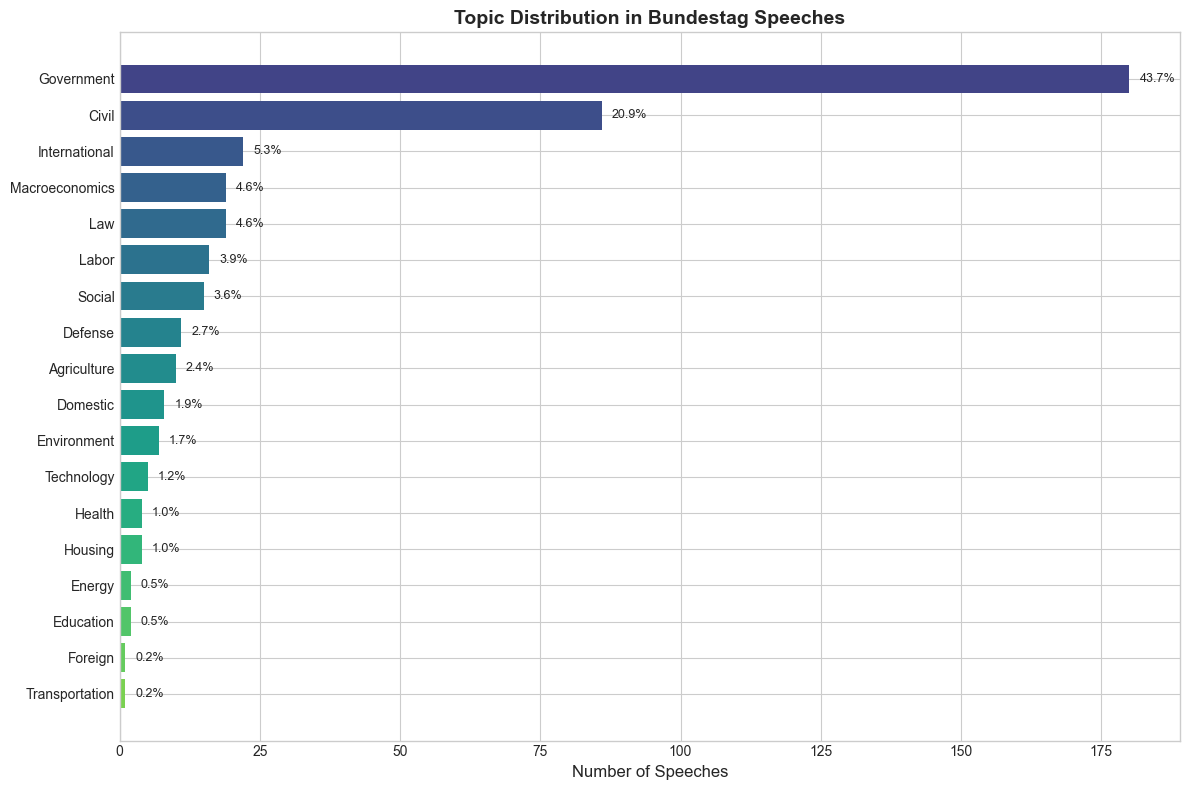


✓ Plot saved to reports/figures/topic_distribution.png


In [33]:
# Visualize topic distribution as horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 8))

topics = topic_summary['topic'].to_list()
counts = topic_summary['total_speeches'].to_list()
percentages = topic_summary['percentage'].to_list()

# Create horizontal bar chart
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(topics)))
bars = ax.barh(range(len(topics)), counts, color=colors)

# Add percentage labels
for i, (count, pct) in enumerate(zip(counts, percentages)):
    ax.text(count + max(counts)*0.01, i, f'{pct:.1f}%', va='center', fontsize=9)

ax.set_yticks(range(len(topics)))
ax.set_yticklabels(topics)
ax.invert_yaxis()  # Most common at top
ax.set_xlabel('Number of Speeches', fontsize=12)
ax.set_title('Topic Distribution in Bundestag Speeches', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/topic_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Plot saved to reports/figures/topic_distribution.png")

## 3. Sentiment by Party Over Time

Which party spoke with the highest sentiment score over time?

In [34]:
# Calculate average sentiment by party over time
party_sentiment_time = (
    df.group_by(['year_month', 'party_name'])
    .agg([
        pl.col('sentiment_score').mean().alias('avg_sentiment'),
        pl.len().alias('speech_count')
    ])
    .sort(['year_month', 'party_name'])
)

# Get parties with sufficient speeches
party_counts = df.group_by('party_name').agg(pl.len().alias('total')).sort('total', descending=True)
print("Party speech counts:")
print(party_counts)

# Filter to parties with at least 5 speeches for meaningful analysis
active_parties = party_counts.filter(pl.col('total') >= 5)['party_name'].to_list()
print(f"\nParties with >= 5 speeches: {active_parties}")

# Debug: Check party_sentiment_time data
print(f"\nParty sentiment time data shape: {party_sentiment_time.shape}")
print(party_sentiment_time.head(10))

Party speech counts:
shape: (7, 2)
┌────────────┬───────┐
│ party_name ┆ total │
│ ---        ┆ ---   │
│ str        ┆ u32   │
╞════════════╪═══════╡
│ CDU        ┆ 236   │
│ SPD        ┆ 95    │
│ Unknown    ┆ 45    │
│ FDP        ┆ 29    │
│ Greens     ┆ 5     │
│ Zentrum    ┆ 1     │
│ DP         ┆ 1     │
└────────────┴───────┘

Parties with >= 5 speeches: ['CDU', 'SPD', 'Unknown', 'FDP', 'Greens']

Party sentiment time data shape: (59, 4)
shape: (10, 4)
┌────────────┬────────────┬───────────────┬──────────────┐
│ year_month ┆ party_name ┆ avg_sentiment ┆ speech_count │
│ ---        ┆ ---        ┆ ---           ┆ ---          │
│ str        ┆ str        ┆ f64           ┆ u32          │
╞════════════╪════════════╪═══════════════╪══════════════╡
│ 1952-01    ┆ Zentrum    ┆ -1.0          ┆ 1            │
│ 1953-03    ┆ DP         ┆ 0.0           ┆ 1            │
│ 1954-02    ┆ CDU        ┆ 0.0           ┆ 2            │
│ 1956-07    ┆ SPD        ┆ 0.0           ┆ 4            │
│ 1957

Filtered party data shape: (57, 4)
Active parties: ['CDU', 'SPD', 'Unknown', 'FDP', 'Greens']
Time periods: ['1954-02', '1956-07', '1957-07', '1959-10', '1961-06', '1964-11', '1967-10', '1967-11', '1968-03', '1968-06', '1969-02', '1969-03', '1971-03', '1974-02', '1974-10', '1975-05', '1975-11', '1977-01', '1978-06', '1980-06', '1982-12', '1983-09', '1984-05', '1985-01', '1986-06', '1987-12', '1989-02', '1991-06', '1992-02', '1992-09', '1995-11', '1996-02', '1997-10', '1997-11', '1998-05', '1998-12', '1999-03', '1999-04', '1999-11', '2002-04', '2003-04', '2003-06', '2006-01', '2006-06', '2008-09', '2009-04', '2010-02', '2010-05', '2010-06', '2012-12', '2013-06', '2018-11', '2019-06', '2019-09', '2019-10', '2019-11', '2020-09']
Plotted CDU: 18 data points
Plotted SPD: 12 data points
Plotted Unknown: 17 data points
Plotted FDP: 7 data points
Plotted Greens: 3 data points


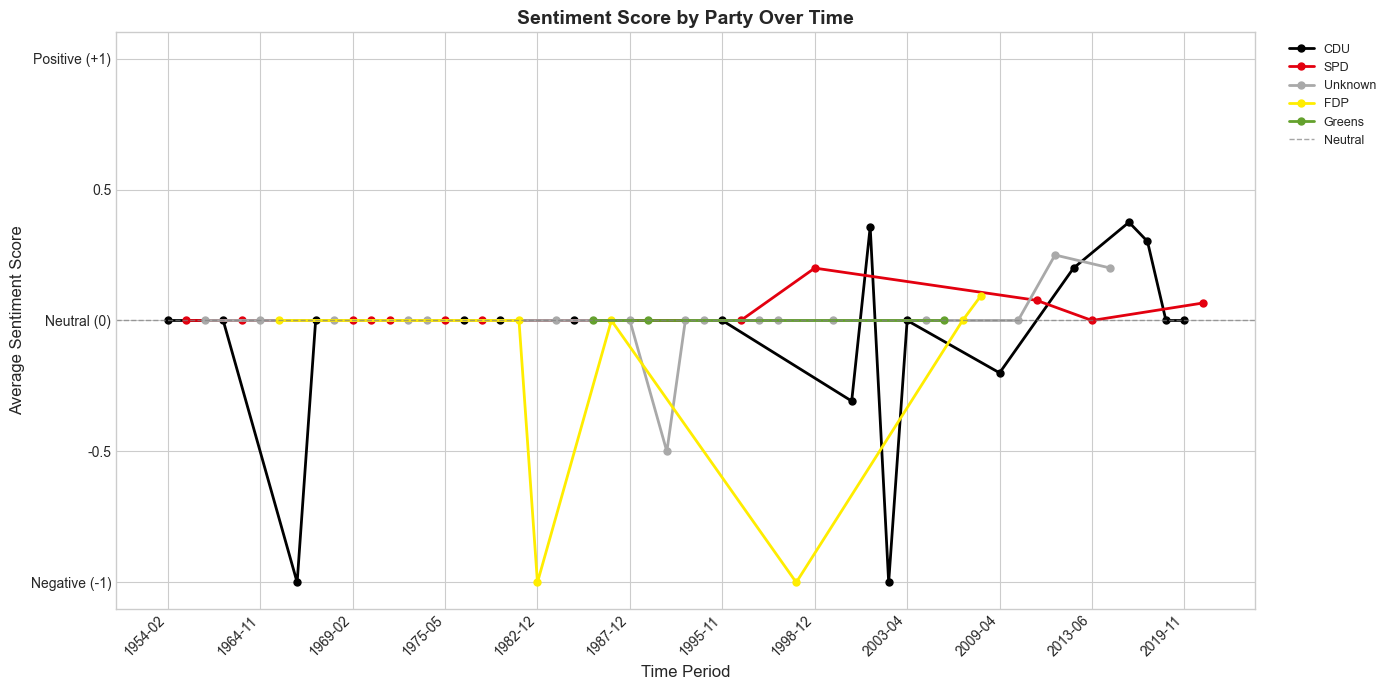


✓ Plot saved to reports/figures/sentiment_by_party_over_time.png


In [35]:
# Create sentiment over time plot by party
fig, ax = plt.subplots(figsize=(14, 7))

# Filter to active parties
party_data = party_sentiment_time.filter(pl.col('party_name').is_in(active_parties))

print(f"Filtered party data shape: {party_data.shape}")
print(f"Active parties: {active_parties}")

# Get unique time periods
time_periods = sorted(party_data['year_month'].unique().to_list())
print(f"Time periods: {time_periods}")

# Define party colors (German political party colors)
party_colors = {
    'CDU': '#000000',      # Black
    'SPD': '#E3000F',      # Red
    'FDP': '#FFED00',      # Yellow
    'Greens': '#64A12D',   # Green
    'Left': '#BE3075',     # Magenta
    'DP': '#0080FF',       # Blue
    'Zentrum': '#8B4513',  # Brown
    'Non-MP': '#808080',   # Gray
    'Unknown': '#A9A9A9',  # Dark Gray
}

# Plot each party
for idx, party in enumerate(active_parties):
    party_subset = party_data.filter(pl.col('party_name') == party)
    
    if party_subset.shape[0] == 0:
        print(f"Warning: No data for party {party}")
        continue
    
    # Create complete time series
    sentiment_dict = dict(zip(
        party_subset['year_month'].to_list(),
        party_subset['avg_sentiment'].to_list()
    ))
    
    # Get valid data points (non-None)
    valid_times = []
    valid_sentiments = []
    for i, t in enumerate(time_periods):
        s = sentiment_dict.get(t)
        if s is not None:
            valid_times.append(i)
            valid_sentiments.append(s)
    
    if valid_times:
        color = party_colors.get(party, plt.cm.tab10.colors[idx % 10])
        ax.plot(valid_times, valid_sentiments, label=party, 
                color=color, linewidth=2, marker='o', markersize=5)
        print(f"Plotted {party}: {len(valid_times)} data points")
    else:
        print(f"No valid sentiment data for {party}")

# Add reference line at 0 (neutral)
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7, label='Neutral')

# Customize plot
ax.set_xlabel('Time Period', fontsize=12)
ax.set_ylabel('Average Sentiment Score', fontsize=12)
ax.set_title('Sentiment Score by Party Over Time', fontsize=14, fontweight='bold')

# Set y-axis limits
ax.set_ylim(-1.1, 1.1)
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.set_yticklabels(['Negative (-1)', '-0.5', 'Neutral (0)', '0.5', 'Positive (+1)'])

# Set x-axis labels
if time_periods:
    tick_positions = range(0, len(time_periods), max(1, len(time_periods)//10))
    ax.set_xticks(list(tick_positions))
    ax.set_xticklabels([time_periods[i] for i in tick_positions], rotation=45, ha='right')

ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.savefig('../reports/figures/sentiment_by_party_over_time.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Plot saved to reports/figures/sentiment_by_party_over_time.png")

In [36]:
# Summary: Overall sentiment by party
party_sentiment_summary = (
    df.group_by('party_name')
    .agg([
        pl.len().alias('total_speeches'),
        pl.col('sentiment_score').mean().alias('avg_sentiment'),
        pl.col('sentiment_score').std().alias('sentiment_std'),
        (pl.col('sentiment') == 'positive').sum().alias('positive_count'),
        (pl.col('sentiment') == 'neutral').sum().alias('neutral_count'),
        (pl.col('sentiment') == 'negative').sum().alias('negative_count')
    ])
    .sort('avg_sentiment', descending=True)
)

print("="*80)
print("SENTIMENT SUMMARY BY PARTY")
print("="*80)
print(party_sentiment_summary)

# Save summary
party_sentiment_summary.write_csv('../reports/tables/sentiment_by_party_summary.csv')
print("\n✓ Table saved to reports/tables/sentiment_by_party_summary.csv")

SENTIMENT SUMMARY BY PARTY
shape: (7, 7)
┌────────────┬──────────────┬──────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│ party_name ┆ total_speech ┆ avg_sentimen ┆ sentiment_s ┆ positive_co ┆ neutral_cou ┆ negative_co │
│ ---        ┆ es           ┆ t            ┆ td          ┆ unt         ┆ nt          ┆ unt         │
│ str        ┆ ---          ┆ ---          ┆ ---         ┆ ---         ┆ ---         ┆ ---         │
│            ┆ u32          ┆ f64          ┆ f64         ┆ u32         ┆ u32         ┆ u32         │
╞════════════╪══════════════╪══════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ CDU        ┆ 236          ┆ 0.216102     ┆ 0.61878     ┆ 76          ┆ 135         ┆ 25          │
│ SPD        ┆ 95           ┆ 0.094737     ┆ 0.527412    ┆ 18          ┆ 68          ┆ 9           │
│ Unknown    ┆ 45           ┆ 0.088889     ┆ 0.468179    ┆ 7           ┆ 35          ┆ 3           │
│ Greens     ┆ 5            ┆ 0.0          ┆ 0.0  

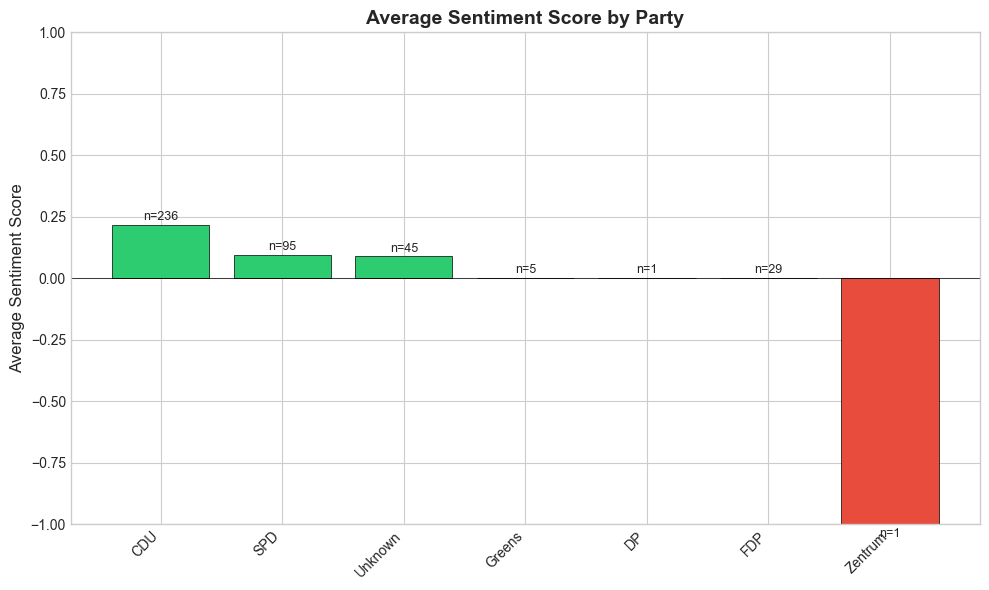


✓ Plot saved to reports/figures/sentiment_by_party_comparison.png


In [37]:
# Create a bar chart comparing average sentiment by party
fig, ax = plt.subplots(figsize=(10, 6))

parties = party_sentiment_summary['party_name'].to_list()
sentiments = party_sentiment_summary['avg_sentiment'].to_list()
counts = party_sentiment_summary['total_speeches'].to_list()

# Color bars based on sentiment (green=positive, red=negative) - handle None values
colors = []
for s in sentiments:
    if s is None:
        colors.append('#95a5a6')  # Gray for None
    elif s > 0:
        colors.append('#2ecc71')  # Green for positive
    elif s < 0:
        colors.append('#e74c3c')  # Red for negative
    else:
        colors.append('#95a5a6')  # Gray for neutral

# Replace None with 0 for plotting
sentiments_clean = [s if s is not None else 0 for s in sentiments]

bars = ax.bar(range(len(parties)), sentiments_clean, color=colors, edgecolor='black', linewidth=0.5)

# Add count labels on bars
for i, (sent, count) in enumerate(zip(sentiments_clean, counts)):
    y_pos = sent + 0.02 if sent >= 0 else sent - 0.05
    ax.text(i, y_pos, f'n={count}', ha='center', fontsize=9)

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xticks(range(len(parties)))
ax.set_xticklabels(parties, rotation=45, ha='right')
ax.set_ylabel('Average Sentiment Score', fontsize=12)
ax.set_title('Average Sentiment Score by Party', fontsize=14, fontweight='bold')
ax.set_ylim(-1, 1)

plt.tight_layout()
plt.savefig('../reports/figures/sentiment_by_party_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Plot saved to reports/figures/sentiment_by_party_comparison.png")

## Summary

This analysis revealed:
1. **Topic trends over time** - showing which policy areas dominated Bundestag debates
2. **Most relevant topics** - ranked by frequency with confidence and sentiment metrics
3. **Party sentiment patterns** - how different parties' rhetorical tone varies over time